In [1]:
import keras
from skimage import io
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.simplefilter('ignore')

Using TensorFlow backend.


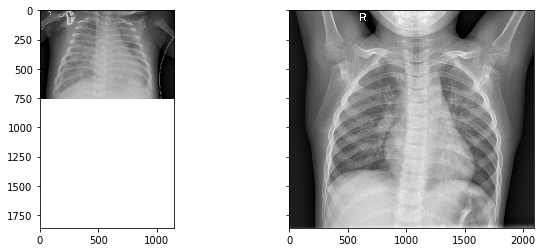

In [5]:
#creating the path
DATASET_PATH = 'chest_xray/train'

#2 classes
disease_cls = ['PNEUMONIA', 'NORMAL']


#reading sample images in each class
effusion_path = os.path.join(DATASET_PATH, disease_cls[0], '*')
effusion = glob.glob(effusion_path)
effusion = io.imread(effusion[0])

normal_path = os.path.join(DATASET_PATH, disease_cls[1], '*')
normal = glob.glob(normal_path)
normal = io.imread(normal[0])

f, axes = plt.subplots(1, 2, sharey = True)
f.set_figwidth(10)

axes[0].imshow(effusion, cmap = 'gray')
axes[1].imshow(normal, cmap= 'gray')

In [6]:
effusion.shape

(760, 1152)

In [7]:
normal.shape

(1858, 2090)

# Data Augmentation
using ImageDataGenerator

In [ ]:
from skimage.transform import rescale
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    featurewise_center = True,
    featurewise_std_normalization = True,
    rotation_range = 10,
    width_shift_range = 0,
    height_shift_range = 0,
    vertical_flip = False
)

def preprocess_img(img, mode):
    img = (img - img.min())/(img.max()- img.min())
    img = rescale(img, 0.25, multichannel = True, mode = 'constant') #resizing image to 25%
    
    if mode == 'train': #if it is training mode, do data augmentation
        if np.random.randn()>0:
            img = datagen.random_transform(img)
            
        return img
    
    

# Model Building
we are using resnet

In [8]:
import resnet

img_channel = 1
img_rows = 256
img_cols = 256

nb_classes = 2

ModuleNotFoundError: No module named 'resnet'

In [ ]:
import numpy as np
import keras

class AugmentedDataGenerator(keras.utils.Sequence):
    'Generate data for keras'
    def __init__(self, mode = 'train', ablation = None, disease_cls = ['nonfinding', 'effusion'],
                batch_size = 32, dim = (256, 256), n_channels = 1, shuffle = True):
        'Initialization'
        self.dim = dim,
        self.batch_size = batch_size,
        self.labels = {},
        self.list_IDs = [],
        self.mode = mode
        
        for i, cls in enumerate(disease_cls):
            paths = glob.glob(os.path.join(DATASET_PATH, cls, '*'))
            brk_point = int(len(paths)*0.8)
            if self.mode == 'train':
                paths = paths[:brk_point]
                
            else:
                paths = paths[brk_point:]
            if ablation is not None:
                paths = paths[:int(len(paths)*ablation/100)]
            self.list_IDs += paths
            self.labels.update({p:i for p in paths})
            
        self.n_channels = n_channels
        self.n_channels = len(disease_cls)
        self.shuffle = shuffle
        self.on_epoch_end()
        
    def __len__(seldf):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.lsit_IDs)/self.batch_size))
    
    def __getitem__(self, index):
        'Generate one batch data'
        indexes = self.indexes[index*self.batch_size: (index+1)*self.batch_size]
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        X, y = self.__data_generation(list_IDs_temp)
        return X, y
    
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    def __data_generation(self, list_IDs_temp):
        'Generate data containing batch_size samples'
        x= np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype = int)
        
        delete_rows = []
        
        for i, ID in enumerate(list_IDs_temp):
            img = io.imread(ID)
            img = img[:, :, np.newaxis]
            if img.shape == (1024, 1024, 1):
                img = preprocess_img(img, self.mode)
                X[i,] = img
                y[i] = self.lables[ID]
                
            else:
                delete_rows.append(i)
                continue
                
        x = np.delete(X, delete_rows, axis =0)
        y = np.delete(y, delete_rows, axis =0)
        
        return X, keras.utils.to_categorical(y, num_classes = self.n_classes)
                
        
    



# Ablation to check if model works

In [ ]:
model = resnet.ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
model.compile(loss = 'categorical_crossentropy', optimizer = 'SGD', metrics = ['accuracy'])

training_generator = AugmentedDataGenerator('train', ablation =5)
validataion_generator = AugmentedDataGenerator('val', ablation = 5)

model.fit_generator(generator = training_generator, 
                   validation_data = validation_generator,
                   epochs = 1)


In [ ]:
#Checking for overfitting
model = resnet.ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
model.compile(loss = 'categorical_crossentropy', optimizer = 'SGD', metrics = ['accuracy'])

training_generator = AugmentedDataGenerator('train', ablation =5)
validataion_generator = AugmentedDataGenerator('val', ablation = 5)

model.fit_generator(generator = training_generator, 
                   validation_data = None,
                   epochs = 5)


In [ ]:
#Using auc becauase accuracy is not an appropriate metric in this case.
from sklearn.metrics import roc_auc_score
from keras import optimizers
from keras.callbacks import *

class roc_callback(Callback):
    def on_train_begin(self, logs ={}):
        logs['val_auc'] = 0
        
    def on_epoch_end(self, logs={}):
        y_p = []
        y_v = []
        for i in range(len(validation_generator)):
            x_val, y_val = validation_generator[i]
            y_pred = self.model.predict(x_val)
            y_p.append(y_pred)
            y_v.append(y_val)
        y_p = np.concatenate(y_p)
        y_v = np.concatenate(y_v)
        roc_auc = roc_auc_score(y_v, y_p)
        print('\nVal AUC for epoch{}: {}'.format(epoch, roc_auc))
        logs['val_auc'] = roc_auc

In [ ]:
model = resnet.ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
model.compile(loss = 'categorical_crossentropy', optimizer = 'SGD', metrics = ['accuracy'])

training_generator = AugmentedDataGenerator('train', ablation =20)
validataion_generator = AugmentedDataGenerator('val', ablation = 20)

auc_logger = roc_callback()

model.fit_generator(generator = training_generator, 
                   validation_data = validation_generator,
                   epochs = 5, callbacks = [auc_logger])

from above cell, auc is 0.19... but a good alue for auc should lie between 0.5 and 1.
This is an indicator that the model is not learning much. It is confused. It thinks 1 is 0 and 0 is 1
This is partlt due to class imbalance. Many more normal than abnormal images

Solution is to take weigted cross entropy
This means that everytime the model misclassifies on the abnormal smaller data, we penelize it by multiplying the loss with a big weight

In [ ]:
#configuring crossentropy
from functools import partial
import keras.backend as K
from itertools import product

def w_categorical_crossentropy(y_true, y_pred, weights):
    nb_cl = len(weights)
    final_mask = K.zeros_like(y_pred[:, 0])
    y_pred_max = K.max(y_pred, axis =1)
    y_pred_max = K.reshape(y_pred_max, (K.shape(y_pred)[0], 1))
    y_pred_max_mat = K.cast(K.equal(y_pred, y_pred_max), K.floatx())
    for c_p, c_t in product(range(nb_cl), range(nb_cl)):
        final_mask += (weights[c_t, c_p] *y_pred_max_mat[:, c_p] *y_true[:, c_t])
    cross_ent = K.categorical_crossentropy(y_true, y_pred, from_logits = False)
    return cross_ent * final_mask

bin_weights = np.ones((2, 2))
bin_weights[0, 1] = 5
bin_weights[1, 0] = 5
ncce = partial(w_categorical_crossentropy, weights = bin_weights)
ncce.__name__ = 'w_categorical_crossentropy'

In [ ]:
#now ussing ncc instead of categorical_crossentropy
model = resnet.ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
model.compile(loss = ncce, optimizer = 'SGD', metrics = ['accuracy'])

training_generator = AugmentedDataGenerator('train', ablation =5)
validataion_generator = AugmentedDataGenerator('val', ablation = 5)


model.fit_generator(generator = training_generator, 
                   validation_data = None,
                   epochs = 1)

In [ ]:
#Another run using deacy running rate
class DecayLR(keras.callbacks.Callback):
    def __init__(self,, base_lr =0.01, decay_epochs =1):
        super(DecayLR, self).__init__()
        self.base_lr = base_lr
        self.decay_epoch = decay_epoch
        self.lr_history =[]
        
    def on_train_begin(self, logs ={}):
        K.set_value(self.model.optimizer.lr, slef.base_lr)
        
    def on_epoch_end(self, epoch, logs = {}):
        new_lr = self.base_lr *(0.5 **(epoch//self.decay_epoch))
        self.lr_history.append(K.get_value(self.model.optimizer.lr))
        K.set_value(self.model.optimizer.lr, new_lr)
        

In [ ]:
model = resnet.ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
sgd = optimizer.SGD(lr = 0.005)

bin_weights = np.ones((2, 2))
bin_weights[1, 1] = 10
bin_weights[1, 0] = 10
ncce = partial(w_categorical_crossentropy, weights = bin_weights)
ncce.__name__ = 'w_categorical_crossentropy'



model.compile(loss = ncce, optimizer = sgd, metrics = ['accuracy'])

training_generator = AugmentedDataGenerator('train', ablation =50)
validataion_generator = AugmentedDataGenerator('val', ablation = 50)


auc_logger = roc_callback()
filepath = 'models/best_model.hdf5'
checkpoint = ModelCheckpont(filepath, monitor = 'val_auc', verbose = 1, save_best_only = True, mode = 'max')

decay = DecayLR()



model.fit_generator(generator = training_generator, 
                   validation_data = validation_generator,,
                   epochs = 10, callbacks = [auc_logger, decay, checkpoint])


Test model with a prediction

In [ ]:
val_model = resnet.ResnetBuilder.build_resnet_18((img_channels, img_rows, img_cols), nb_classes)
val_model.load_weights('models/best_model.hdf5')


In [ ]:
effusion = io.imread(effusion[-8])
plt.imshow(effusion, cmap = 'gray')

In [9]:
img = preprocess_img(effusion[:, :, np.newaxis], 'validation')
val_model.predict(img[np.newaxis, :])

NameError: name 'preprocess_img' is not defined